#Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os


In [ ]:
path='/content/drive/MyDrive/HK4_N2/NLP/FinalProject/Data//'
os.chdir(path)


In [ ]:
df = pd.read_csv("jobs_dataset_with_features.csv")

In [ ]:
df.shape

(1615940, 2)

In [ ]:
df.head()

,Role,Features
0,Social Media Manager,5 to 15 Years Digital Marketing Specialist M.T...
1,Frontend Web Developer,"2 to 12 Years Web Developer BCA HTML, CSS, Jav..."
2,Quality Control Manager,0 to 12 Years Operations Manager PhD Quality c...
3,Wireless Network Engineer,4 to 11 Years Network Engineer PhD Wireless ne...
4,Conference Manager,1 to 12 Years Event Manager MBA Event planning...


In [ ]:
df['Role'].value_counts()

,count
Role,
Interaction Designer,20580
Network Administrator,17470
User Interface Designer,14036
Social Media Manager,13945
User Experience Designer,13935
...,...
Inventory Control Specialist,3342
Budget Analyst,3335
Clinical Nurse Manager,3324


In [ ]:
# Dropping classes with less than 6500 instances
min_count = 6500
role_counts = df['Role'].value_counts()
dropped_classes = role_counts[role_counts < min_count].index
filtered_df = df[~df['Role'].isin(dropped_classes)].reset_index(drop=True)

# Checking the updated role counts
filtered_df['Role'].value_counts()

,count
Role,
Interaction Designer,20580
Network Administrator,17470
User Interface Designer,14036
Social Media Manager,13945
User Experience Designer,13935
...,...
Benefits Coordinator,6839
Research Analyst,6830
Administrative Coordinator,6803


In [ ]:
len(filtered_df['Role'].value_counts())

61

In [ ]:
df = filtered_df.sample(n=10000)

In [ ]:
df.head()

,Role,Features
247046,Content Creator,1 to 14 Years Social Media Coordinator PhD Con...
22551,Customer Success Manager,3 to 10 Years Customer Support Specialist B.Co...
464283,Data Entry Specialist,5 to 13 Years Administrative Assistant BA Data...
64708,UI/UX Designer,1 to 10 Years Graphic Designer M.Com User inte...
218326,Frontend Developer,4 to 9 Years Software Engineer M.Com Proficien...


#TFIDF

In [ ]:
# Splitting the data into features (X) and target (y)
X = df['Features']
y = df['Role']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Label encoding for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Mapping to convert predictions back to original categories
original_categories = label_encoder.classes_
label_mapping = {i: label for i, label in enumerate(original_categories)}

SVM Model Accuracy: 1.0


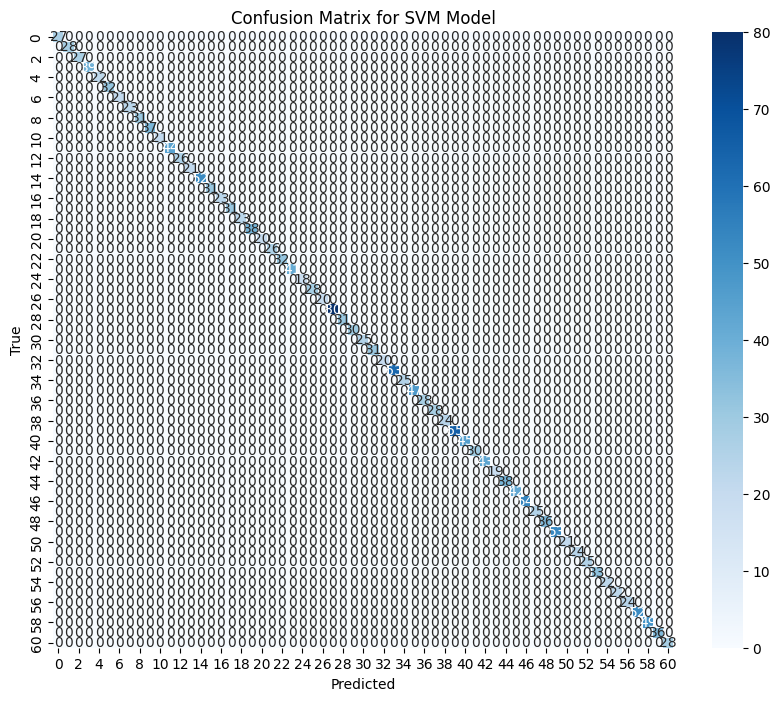

In [ ]:
# Using XGBoost for job recommendation (replacing SVM)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Make predictions with encoded values
y_pred_encoded = xgb_model.predict(X_test_tfidf)

# Convert predictions back to original category names
y_pred = [label_mapping[pred] for pred in y_pred_encoded]




#Recommendation

In [ ]:
# Clean resume
import re
def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText


# Prediction and Category Name using XGBoost
def job_recommendation(resume_text):
    resume_text = cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer.transform([resume_text])
    # Get the encoded prediction
    encoded_pred = xgb_model.predict(resume_tfidf)[0]
    # Convert back to original category name
    predicted_category = label_mapping[encoded_pred]
    return predicted_category

In [ ]:
# Example Usage
resume_file = """Objective:
A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to leverage design skills in a dynamic and collaborative environment.

Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills

Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
- Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

Freelance Designer
- Designed logos, branding materials, and website layouts for small businesses and startups
- Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
- Established and maintained strong client relationships through clear communication and exceptional service

Projects:
- Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in a 30% increase in brand recognition
- Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a successful launch and positive customer feedback

Certifications:
- Adobe Certified Expert (ACE) in Adobe Illustrator
- Responsive Web Design Certification from Udemy

Languages:
- English (Native)
- Spanish (Intermediate)
"""
predicted_category = job_recommendation(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: User Interface Designer


In [ ]:
# Example Usage
resume_file = """Objective:
Dedicated and results-oriented Banking professional with a strong background in financial analysis and customer service seeking opportunities to contribute to a reputable financial institution. Eager to leverage expertise in risk management, investment strategies, and relationship building to drive business growth and client satisfaction.

Education:
- Bachelor of Business Administration in Finance, XYZ University, GPA: 3.8/4.0
- Certified Financial Analyst (CFA) Level I Candidate

Skills:
- Proficient in financial modeling and analysis using Excel, Bloomberg Terminal, and other financial software
- Extensive knowledge of banking products and services, including loans, mortgages, and investment products
- Strong understanding of regulatory compliance and risk management practices in the banking industry
- Excellent communication and interpersonal skills, with a focus on building rapport with clients and colleagues
- Ability to work efficiently under pressure and adapt to changing market conditions

Experience:
Financial Analyst | ABC Bank
- Conducted financial analysis and risk assessment for corporate clients, including credit analysis, financial statement analysis, and cash flow modeling
- Developed customized financial solutions to meet clients' needs and objectives, resulting in increased revenue and client retention
- Collaborated with cross-functional teams to identify new business opportunities and optimize existing processes

Customer Service Representative | DEF Bank
- Provided exceptional customer service to bank clients, addressing inquiries, resolving issues, and promoting banking products and services
- Processed transactions accurately and efficiently, including deposits, withdrawals, and account transfers
- Educated customers on various banking products and services, helping them make informed financial decisions

Internship | GHI Investments
- Assisted portfolio managers with investment research and analysis, including industry and company-specific research, financial modeling, and performance analysis
- Prepared investment presentations and reports for clients, highlighting investment opportunities and performance metrics
- Conducted market research and analysis to identify trends and opportunities in the financial markets

Certifications:
- Certified Financial Planner (CFP)
- Series 7 and Series 63 Securities Licenses

Languages:
- English (Native)
- Spanish (Proficient)

"""
predicted_category = job_recommendation(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: Financial Analyst


#Save Files

In [ ]:
import pickle

# Save the XGBoost model, label encoder, and vectorizer
model_data = {
    "model": xgb_model,
    "label_encoder": label_encoder,
    "label_mapping": label_mapping
}
pickle.dump(model_data, open('/content/drive/MyDrive/HK4_N2/NLP/FinalProject/models/xgboost_model_job_recommendation.pkl','wb'))
pickle.dump(tfidf_vectorizer, open('/content/drive/MyDrive/HK4_N2/NLP/FinalProject/models/tfidf_vectorizer_job_recommendation.pkl','wb'))



Saved SVM model as it had the highest accuracy in previous analysis
